In [ ]:
# 检查GPU状态和显存使用情况
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [ ]:
# 安装必要的依赖包
# ltp: 用于中文语言技术处理(包含语义角色标注SRL)
# transformers: Hugging Face的预训练模型库
# seaborn, sklearn: 用于可视化和评估指标
%pip install ltp
%pip install -q -U watermark
%pip install -qq transformers
%pip install seaborn
%pip install scikit-learn
%pip install numpy pandas matplotlib
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/Volumes/移动硬盘/Asotck/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Volumes/移动硬盘/Asotck/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.18.1

numpy       : 2.0.2
pandas      : 2.3.3
torch       : 2.8.0
transformers: 4.57.0



In [ ]:
#@title Setup & Config
# 导入所有必要的库
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random
import json
from math import isnan

# 配置matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'

# 设置调色板
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

# 设置图表大小
rcParams['figure.figsize'] = 12, 8

# 设置随机种子以确保实验可复现
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 自动选择设备：有GPU则使用GPU，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 模型和数据加载部分

In [ ]:
# 加载预训练模型的分词器
# 使用哈工大的中文RoBERTa全词遮罩模型，特别适合中文文本处理
from transformers import BertTokenizer,BertModel
PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
# 其他可选的预训练模型：
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"  # 大型中文RoBERTa
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"  # 中文BERT全词遮罩
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"  # 英文BERT
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"  # 金融领域BERT
# PRE_TRAINED_MODEL_NAME = "bert-base-chinese"  # 基础中文BERT

# 初始化分词器，do_lower_case=True表示将文本转为小写
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)

## 生成语义角色标注的Mask矩阵（动词、A0施事、A1受事）

In [ ]:
# ========== 数据加载和预处理 ==========
# 加载训练集、验证集、测试集和分布外(OOD)数据集
df_train = pd.read_csv('../data/train.csv',sep='\t')
df_val = pd.read_csv('../data/val.csv',sep='\t')
df_test = pd.read_csv('../data/test.csv',sep='\t')
df_ood = pd.read_csv('../data/ood.csv',sep='\t')

# 数据清洗：删除语义角色标注信息缺失的样本
df_train = df_train.drop(df_train.loc[df_train.verbA0A1.isna()].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1.isna()].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)

# 删除语义角色标注为空列表的样本
df_train = df_train.drop(df_train.loc[df_train.verbA0A1=='[]'].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1=='[]'].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1=='[]'].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

# 工具函数：将字符串格式的元组列表转换为Python列表
def string_to_tuples_list(text):
  if text is np.nan or text =='[]':
    return []
  text = ''.join(text.split('], ['))
  tmp = eval(text.strip('[').strip(']'))
  if not isinstance(tmp[0],tuple):
    return [tmp]
  return list(tmp)

# 处理verb(动词)、A0(施事)、A1(受事)列：将字符串转换为元组列表
for col in ['verb','A0','A1']:
  df_train[col] = df_train[col].apply(string_to_tuples_list)
  df_val[col] = df_val[col].apply(string_to_tuples_list)
  df_test[col] = df_test[col].apply(string_to_tuples_list)
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

# 处理股票因子和完整的语义角色标注信息：将字符串格式转换为Python对象
for col in ['stock_factors','verbA0A1']:
  df_train[col] = df_train[col].apply(ast.literal_eval)
  df_val[col] = df_val[col].apply(ast.literal_eval)
  df_test[col] = df_test[col].apply(ast.literal_eval)
  df_ood[col] = df_ood[col].apply(ast.literal_eval)

# 核心函数：生成语义角色的mask矩阵
# 将语义角色位置信息转换为mask向量，用于后续模型输入
def mask(df):
  df = df.reset_index(drop = True)
  # 初始化三种mask列：verb_mask, A0_mask, A1_mask
  df['verb_mask'] = 0
  df['A0_mask'] = 0
  df['A1_mask'] = 0
  df['verb_mask'] = df['verb_mask'].astype('object')
  df['A0_mask'] = df['A0_mask'].astype('object')
  df['A1_mask'] = df['A1_mask'].astype('object')
  
  for index,row in df.iterrows():
    # 将股票因子转换为float类型
    df.at[index,'stock_factors'] = [*map(float,df.loc[index,'stock_factors'])]
    AV_num = 0
    
    # 为verb、A0、A1分别生成mask矩阵
    for k,col in enumerate(['verb','A0','A1']):
      masks = []
      # 遍历每个语义角色实例
      for j in range(len(row['verbA0A1'])):
        mask = np.zeros(299)  # 初始化mask向量(长度299)
        idx = []
        # 提取语义角色在文本中的位置信息
        for v in row['verbA0A1'][j][k]:
          # v[0]是起始位置，v[1]是长度
          idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
        
        # 统计每个位置出现的次数
        counter = Counter(idx)
        # 生成归一化的mask：如果位置i在语义角色中出现，值为1/总位置数，否则为0
        mask = [0 if counter[i]== 0 else 1/len(counter) for i in range(0,len(mask))]
        mask.insert(0,0)  # 在开头插入0，对应[CLS] token
        masks.append(mask)
      
      AV_num = len(masks)
      # 将mask数量补齐到10个（不足的补零矩阵）
      for i in range(10 - len(masks)):
        masks.append(np.zeros(300))
      # 如果超过10个，截断到10个
      while len(masks)>10:
        masks.pop()
      
      # 保存mask矩阵到对应的列
      name = col+'_mask'
      df.at[index,name] = np.array(masks)
    
    # 记录实际的语义角色对数量（最多10对）
    if AV_num>10:
      AV_num=10
    df.loc[index,'AV_num'] = int(AV_num)
  
  # 转换数据类型
  df.AV_num = df.AV_num.astype('int')
  df.stock_factors = df.stock_factors.apply(np.array)
  return df

# 对所有数据集应用mask生成函数
df_train = mask(df_train)
df_test = mask(df_test)
df_val = mask(df_val)
df_ood = mask(df_ood)

## 创建数据加载器（DataLoader）

In [ ]:
# ========== 自定义数据集类 ==========
max_len = 300  # 文本最大长度
class_names = ['negative','neutral', 'positive']  # 三分类标签：负面、中性、正面

class GPReviewDataset(Dataset):
  """
  自定义数据集类，用于加载股票评论数据
  包含：文本、标签、股票因子、语义角色mask等信息
  """
  def __init__(self, reviews, targets,verb,A0,A1,AV_num,tokenizer,stock_factors, max_len):
    self.reviews = reviews  # 文本评论
    self.targets = targets  # 标签(0/1/2)
    self.stock_factors = stock_factors  # 24个股票量化因子
    self.verb = verb  # 动词mask
    self.A0 = A0  # A0(施事)mask
    self.A1 = A1  # A1(受事)mask
    self.AV_num = AV_num  # 语义角色对数量
    self.tokenizer = tokenizer  # 分词器
    self.max_len = max_len  # 最大长度
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    """获取单个样本的数据"""
    review = str(self.reviews[item])
    target = self.targets[item]
    stock_factors = self.stock_factors[item]
    v = self.verb[item]
    a0 = self.A0[item]
    a1 = self.A1[item]
    av_num = self.AV_num[item]

    # 使用tokenizer对文本进行编码
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,  # 添加[CLS]和[SEP]特殊token
      max_length=self.max_len,  # 最大长度
      return_token_type_ids=False,  # 不返回token类型ID
      padding='max_length',  # 填充到最大长度
      truncation=True,  # 超长则截断
      return_attention_mask=True,  # 返回attention mask
      return_tensors='pt',  # 返回PyTorch张量
    )

    # 返回一个字典，包含所有必要的输入信息
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'stock_factors':torch.tensor(stock_factors),
      'verb': torch.tensor(v),
      'A0': torch.tensor(a0),
      'A1': torch.tensor(a1),
      'AV_num': torch.tensor(av_num)
    }

In [ ]:
# 创建DataLoader的工具函数
def create_data_loader(df, tokenizer, max_len, batch_size):
  """
  从DataFrame创建PyTorch DataLoader
  参数:
    df: 包含文本、标签、股票因子等信息的DataFrame
    tokenizer: 分词器
    max_len: 最大文本长度
    batch_size: 批次大小
  """
  # 创建数据集对象
  ds = GPReviewDataset(
    reviews=df.text_a.to_numpy(),
    targets=df.label.to_numpy(),
    stock_factors = df.stock_factors,
    verb = df.verb_mask,
    A0 = df.A0_mask,
    A1 = df.A1_mask,
    AV_num = df.AV_num,
    tokenizer=tokenizer,
    max_len=max_len
  )

  # 创建DataLoader，shuffle=True表示每个epoch打乱数据
  return DataLoader(
    ds,
    batch_size=batch_size,
    # num_workers=4,  # 多进程加载数据（已注释）
    shuffle=True
  )

In [ ]:
# 重置所有数据集的索引，确保索引从0开始连续编号
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_ood = df_ood.reset_index(drop=True)

In [ ]:
# 设置批次大小为16
BATCH_SIZE = 16

# 为训练集、验证集、测试集和OOD数据集创建DataLoader
train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

In [ ]:
# 显示当前工作目录
!pwd

/Volumes/移动硬盘/Asotck/Astock/code


## 模型定义（基于RoBERTa + 股票因子融合）

In [ ]:
# ========== 模型定义 ==========
NUMBER_FACTOR = 24  # 股票因子数量

class SentimentClassifier(nn.Module):
  """
  情感分类模型
  架构：BERT编码器 + 股票因子融合 + 全连接分类层
  """
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    # 加载预训练的BERT模型作为编码器
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    
    # 以下是一些可选的架构组件（已注释）
    # self.encoder_layer = nn.TransformerEncoderLayer(d_model=2304+NUMBER_FACTOR, nhead=3)
    # self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
    
    # Dropout层，用于防止过拟合
    self.drop = nn.Dropout(p=0.1)
    # Sigmoid激活函数
    self.sig = nn.Sigmoid()
    
    # 全连接层：处理拼接后的特征(BERT隐层 + 股票因子)
    self.out1 = nn.Linear(self.bert.config.hidden_size+NUMBER_FACTOR, 
                          self.bert.config.hidden_size+NUMBER_FACTOR)
    # 输出层：映射到分类数量
    self.out = nn.Linear(self.bert.config.hidden_size+NUMBER_FACTOR, n_classes)
    # 股票因子的线性变换层
    self.linear_for_stock_factors = nn.Linear(NUMBER_FACTOR, NUMBER_FACTOR)

  def forward(self, input_ids, attention_mask, verb, A0, A1, stock_factors, AV_num):
    """
    前向传播
    注意：虽然传入了verb, A0, A1等语义角色信息，但本模型架构中未直接使用
    这些参数为后续扩展预留
    """
    # 1. 获取BERT的[CLS] token表示（用于句子级分类）
    # [1]表示取pooled_output，即[CLS]位置的隐层表示
    hidden_state = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[1]

    # 2. 处理股票因子
    stock_factors = stock_factors.float()
    # 对股票因子进行线性变换
    stock_factors_batch = self.linear_for_stock_factors(stock_factors)
    
    # 3. 特征融合：将BERT表示和股票因子拼接
    pooled_output = torch.cat([hidden_state, stock_factors_batch], 1)
    
    # 4. 通过全连接层和激活函数
    output = self.sig(pooled_output)
    output = self.out1(output)
    output = self.sig(output)
    output = self.drop(output)
    
    # 5. 最终分类层（未经过softmax，因为损失函数会处理）
    output = self.out(output)

    return output

In [ ]:
# 实例化模型（3分类）并移动到GPU/CPU
model = SentimentClassifier(3)
model = model.to(device)

In [13]:
# ========== 训练配置 ==========
EPOCHS = 1  # 训练轮数

# 优化器：使用AdamW（带权重衰减的Adam）
optimizer = AdamW(model.parameters(), lr=1e-5)

# 计算总训练步数
total_steps = len(train_data_loader) * EPOCHS

# 学习率调度器：线性warmup + 线性衰减
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=2,  # 前2步进行warmup
  num_training_steps=total_steps  # 总训练步数
)

# 损失函数：交叉熵损失（适用于多分类任务）
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# ========== 训练函数 ==========
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  """
  训练一个epoch
  返回：平均准确率和平均损失
  """
  model = model.train()  # 设置为训练模式

  losses = []
  correct_predictions = 0
  correct_predictions_verbs = 0

  # 遍历所有batch
  for d in data_loader:
    # 将数据移动到GPU/CPU
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    stock_factors = d['stock_factors'].to(device)
    verb = d["verb"].to(device)
    A0 = d["A0"].to(device)
    A1 = d["A1"].to(device)
    AV_num = d["AV_num"].to(device)

    # 前向传播
    outputs= model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      verb = verb,
      A0 = A0,
      A1 = A1,
      stock_factors = stock_factors,
      AV_num = AV_num
    )

    # 处理维度问题（如果batch_size=1）
    if outputs.dim()==1:
      outputs = torch.unsqueeze(outputs,0)
    
    # 获取预测类别
    _, preds = torch.max(outputs, dim=1)

    # 计算损失
    loss = loss_fn(outputs, targets)

    # 统计正确预测数量
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    # 反向传播
    loss.backward()
    # 梯度裁剪，防止梯度爆炸
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    # 更新参数
    optimizer.step()
    # 更新学习率
    scheduler.step()
    # 清零梯度
    optimizer.zero_grad()

  # 返回准确率和平均损失
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# ========== 评估函数 ==========
def eval_model(model, data_loader, loss_fn, device, n_examples):
  """
  评估模型在验证集/测试集上的性能
  返回：准确率和平均损失
  """
  model = model.eval()  # 设置为评估模式

  losses = []
  correct_predictions = 0

  # 不计算梯度，节省内存和计算
  with torch.no_grad():
    for d in data_loader:
      # 将数据移动到GPU/CPU
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      stock_factors = d['stock_factors'].to(device)
      verb = d["verb"].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d["AV_num"].to(device)

      # 前向传播
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        stock_factors = stock_factors,
        AV_num = AV_num
      )
      
      # 处理维度问题
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      
      # 获取预测类别
      _, preds = torch.max(outputs, dim=1)
      
      # 计算损失
      loss = loss_fn(outputs, targets)

      # 统计正确预测数量
      correct_predictions += torch.sum(preds == targets)
      
      losses.append(loss.item())

  # 返回准确率和平均损失
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# 初始化训练历史记录和最佳准确率
history = defaultdict(list)  # 记录每个epoch的训练和验证指标
best_accuracy = 0  # 验证集最佳准确率
best_train_accuracy = 0  # 训练集最佳准确率

In [ ]:
# ========== 训练循环 ==========


for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  # 训练一个epoch
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  # 如果训练准确率提升，保存训练最佳模型
  if train_acc > best_train_accuracy:
    torch.save(model.state_dict(), 'best_train_model_state.bin')
    best_train_accuracy = train_acc

  # 在验证集上评估
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  # 记录训练历史
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # 如果验证准确率提升，保存验证最佳模型
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Factor24_Pretrained_ROBERT.bin')
    best_accuracy = val_acc

Epoch 1/1
----------
Train loss 1.01805261055736 accuracy 0.5084214980956412
Val   loss 0.9736008233921503 accuracy 0.5829383886255924



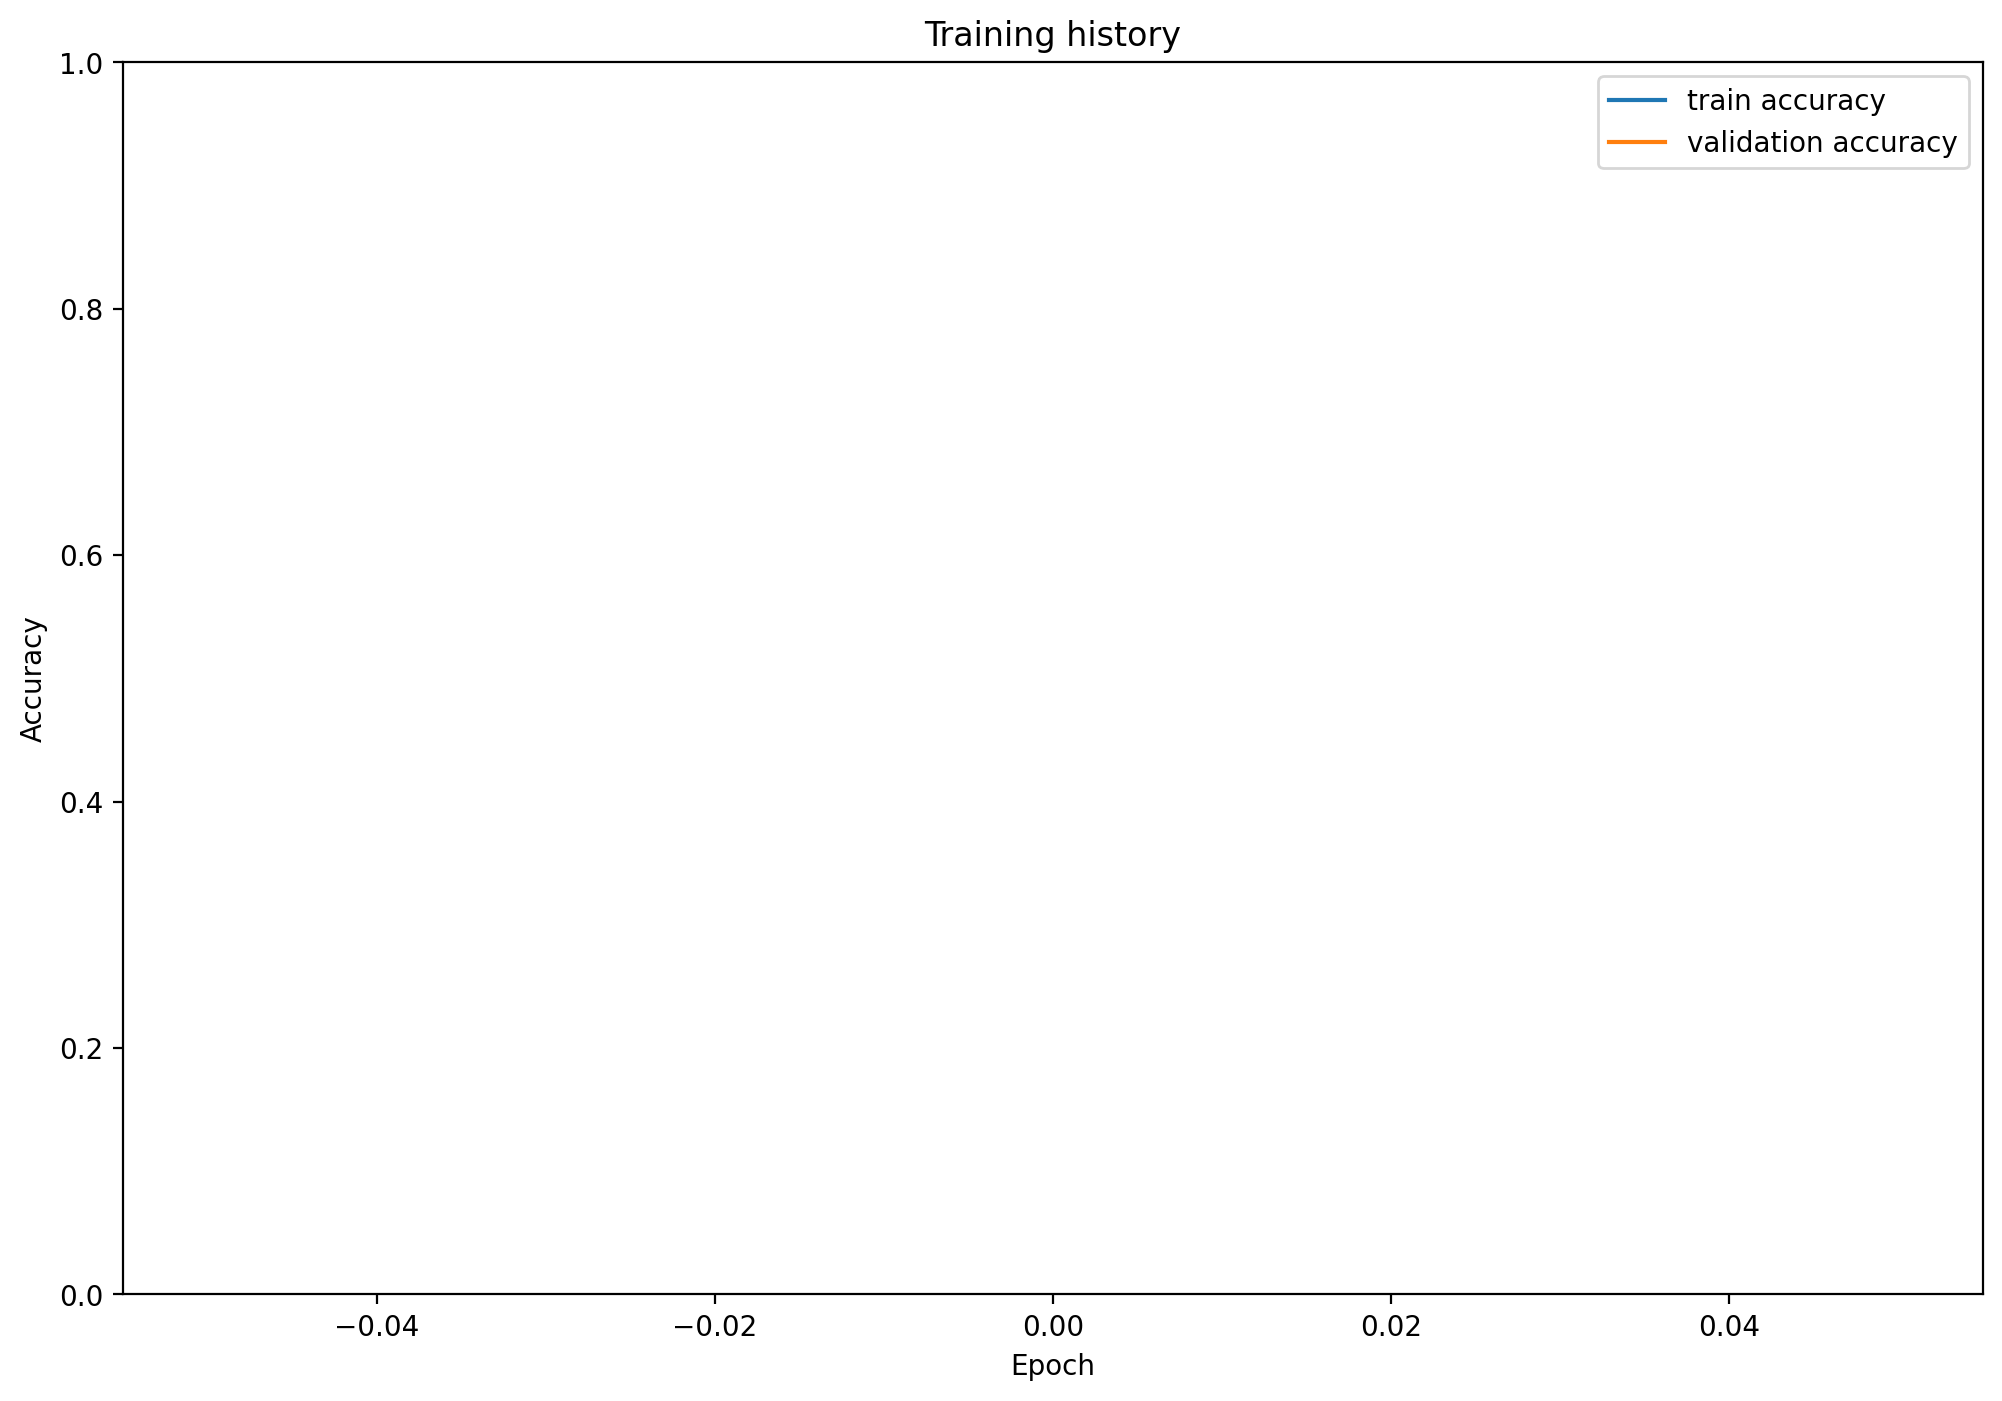

In [ ]:
# ========== 可视化训练历史 ==========
# 绘制训练和验证准确率曲线
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# ========== 加载最佳模型 ==========
# 重新创建模型并加载验证集上表现最佳的权重
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('Factor24_Pretrained_ROBERT.bin'))
model = model.to(device)

In [ ]:
# ========== 测试集评估 ==========
# 在测试集上评估模型性能
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

# 返回测试准确率
test_acc.item()

0.5998645903859174

In [ ]:
# ========== 预测函数 ==========
def get_predictions(model, data_loader):
  """
  获取模型对整个数据集的预测结果
  返回：文本、预测标签、预测概率、真实标签
  """
  model = model.eval()  # 设置为评估模式
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      # 获取数据
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      verb = d["verb"].to(device)
      stock_factors = d['stock_factors'].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d['AV_num'].to(device)

      # 模型前向传播
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        stock_factors = stock_factors,
        AV_num = AV_num
      )
      
      # 获取预测类别
      _, preds = torch.max(outputs, dim=1)

      # 计算softmax概率分布
      probs = F.softmax(outputs, dim=1)

      # 收集所有结果
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  # 将结果转换为tensor并移到CPU
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
# 获取测试集的预测结果
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

### 测试集结果分析

              precision    recall  f1-score   support

    negative     0.6147    0.6756    0.6437       484
     neutral     0.6146    0.4832    0.5410       505
    positive     0.5748    0.6455    0.6081       488

    accuracy                         0.5999      1477
   macro avg     0.6014    0.6014    0.5976      1477
weighted avg     0.6015    0.5999    0.5968      1477



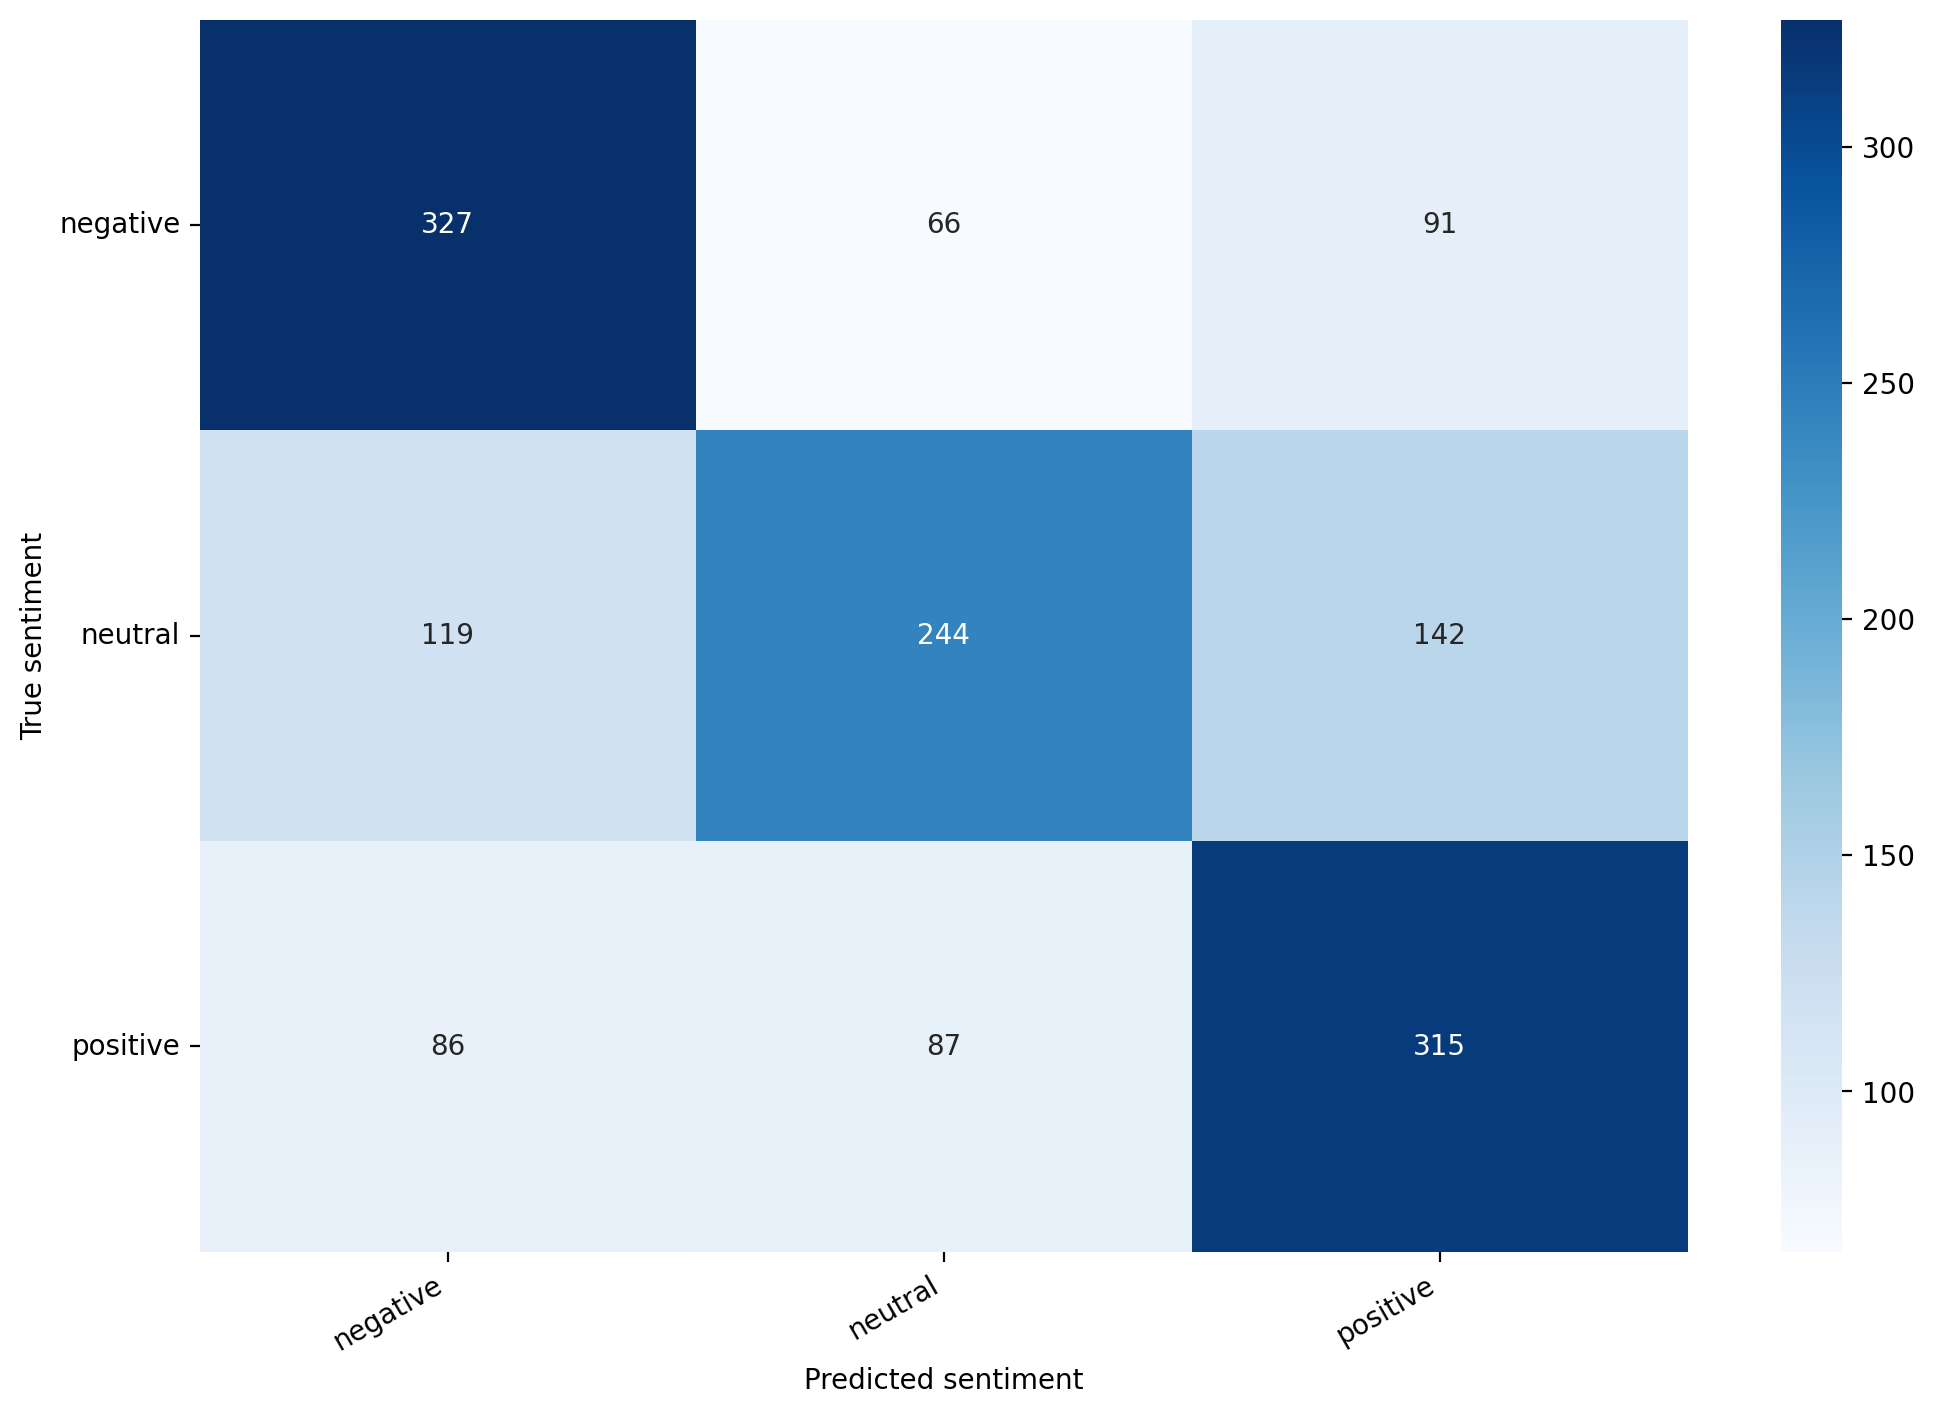

In [ ]:
# ========== 测试集详细结果 ==========
# 打印分类报告（精确率、召回率、F1分数）
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

# 可视化混淆矩阵的函数
def show_confusion_matrix(confusion_matrix):
  """绘制混淆矩阵热力图"""
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

# 计算并显示混淆矩阵
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
# 保存测试集预测结果到CSV文件
df = pd.DataFrame([y_review_texts, y_pred.numpy(), y_pred_probs.numpy(), y_test.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Factor24_Pretrained_ROBERT_test.csv',sep='\t')

### OOD（分布外）数据集结果分析

              precision    recall  f1-score   support

    negative     0.6242    0.6234    0.6238      3133
     neutral     0.5905    0.4645    0.5200      3406
    positive     0.5571    0.6697    0.6083      3618

    accuracy                         0.5866     10157
   macro avg     0.5906    0.5858    0.5840     10157
weighted avg     0.5890    0.5866    0.5834     10157



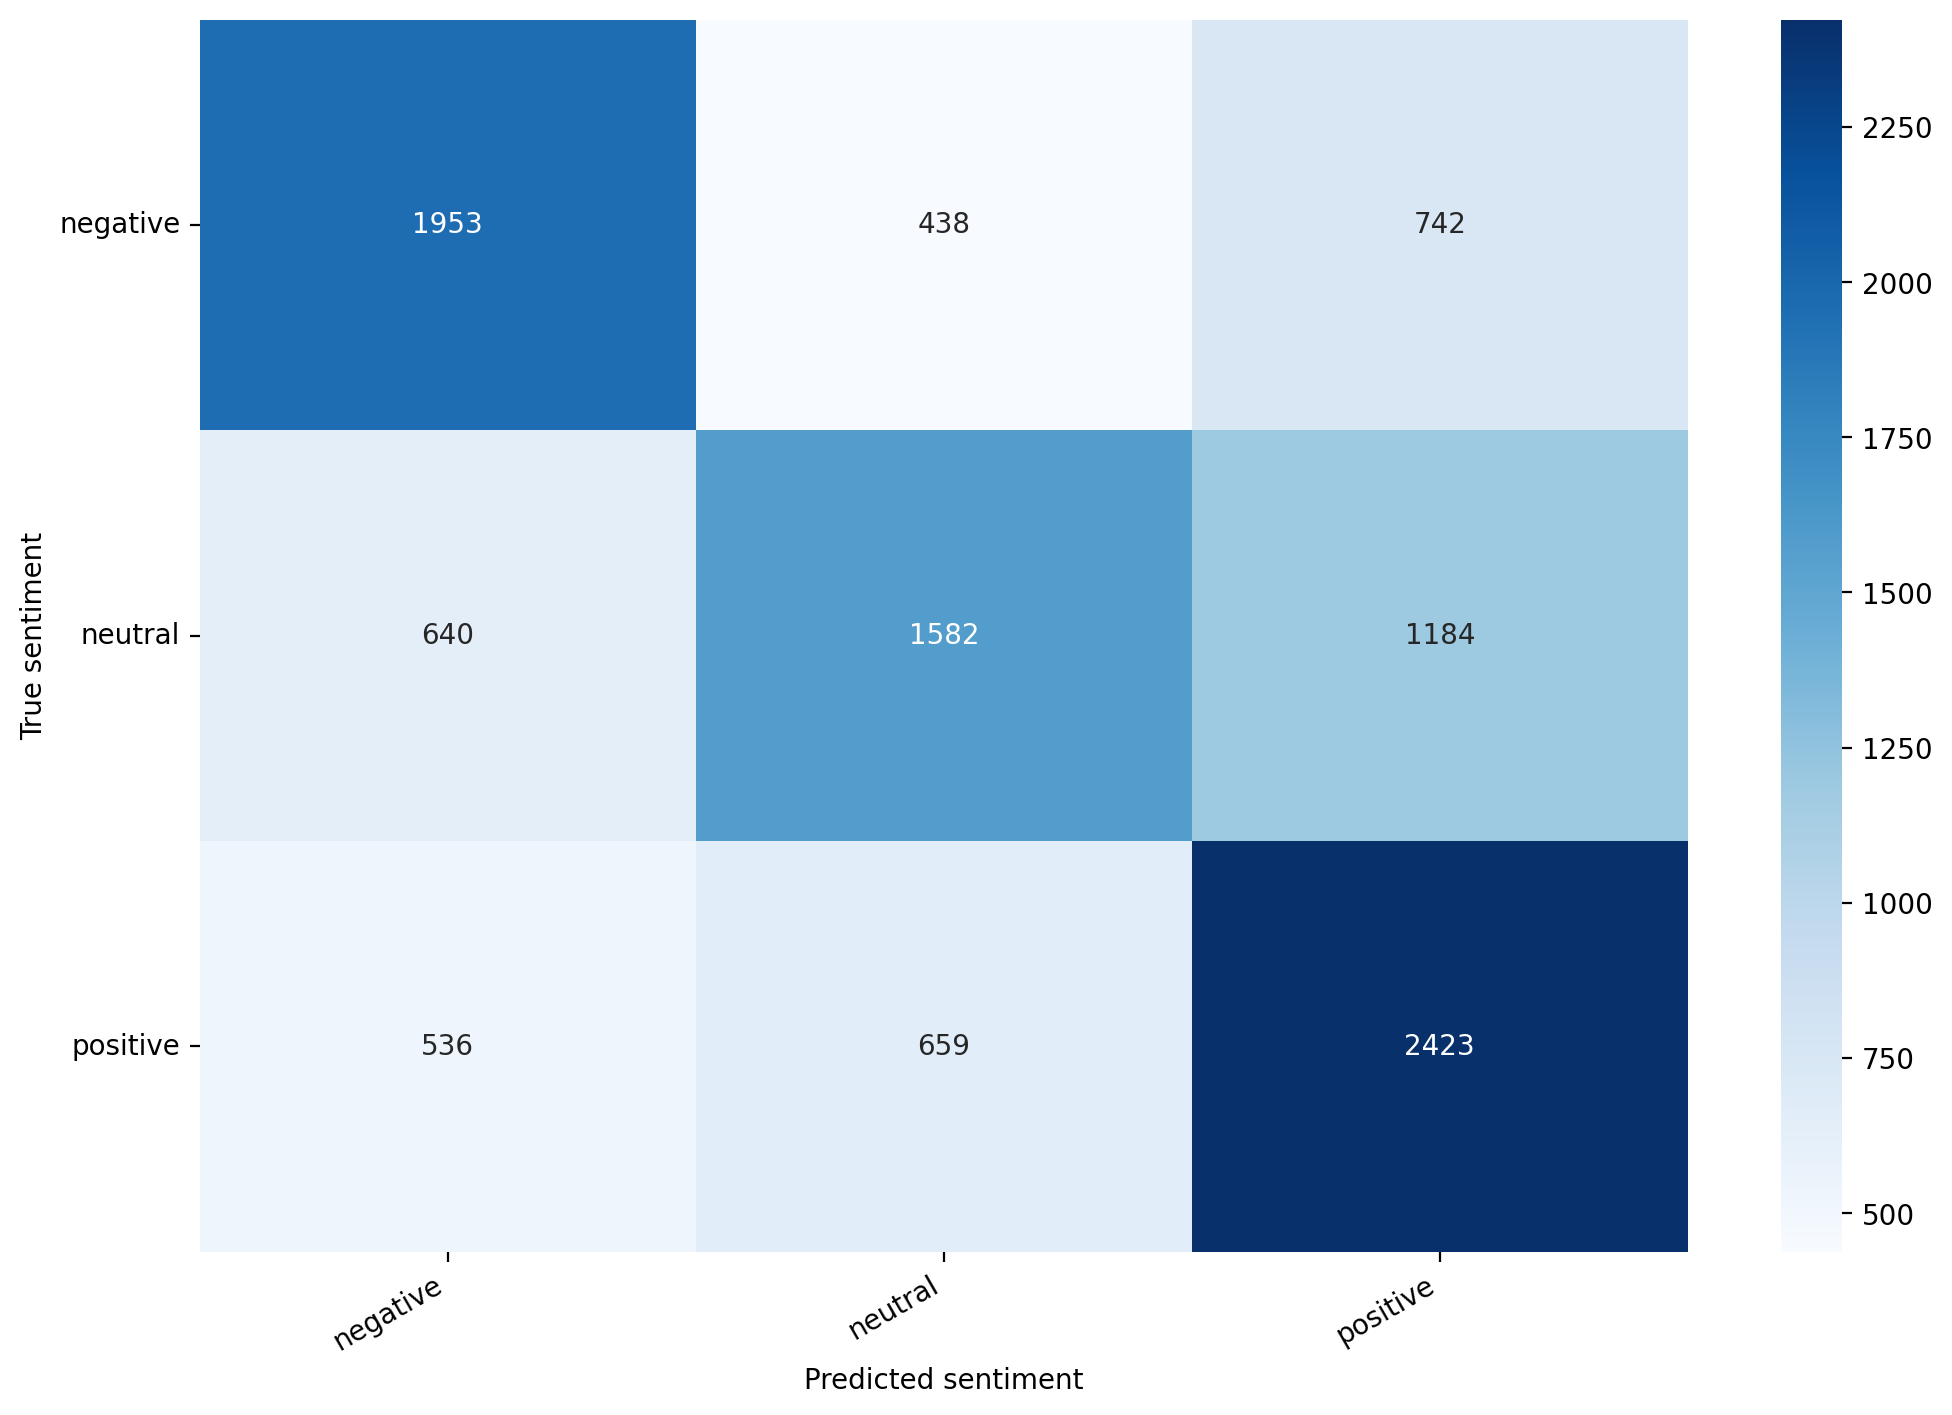

In [ ]:
# ========== OOD（分布外）数据集评估 ==========
# 获取OOD数据集的预测结果
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

# 打印OOD数据集的分类报告
print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

# 计算并显示OOD数据集的混淆矩阵
ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [ ]:
# 保存预测结果（已注释）
# df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
# df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
# df.to_csv('Factor24_Pretrained_ROBERT.csv',sep='\t')

              precision    recall  f1-score   support

    negative     0.6258    0.5907    0.6077       943
     neutral     0.5898    0.4376    0.5024       953
    positive     0.5961    0.7301    0.6563      1330

    accuracy                         0.6029      3226
   macro avg     0.6039    0.5861    0.5888      3226
weighted avg     0.6029    0.6029    0.5966      3226



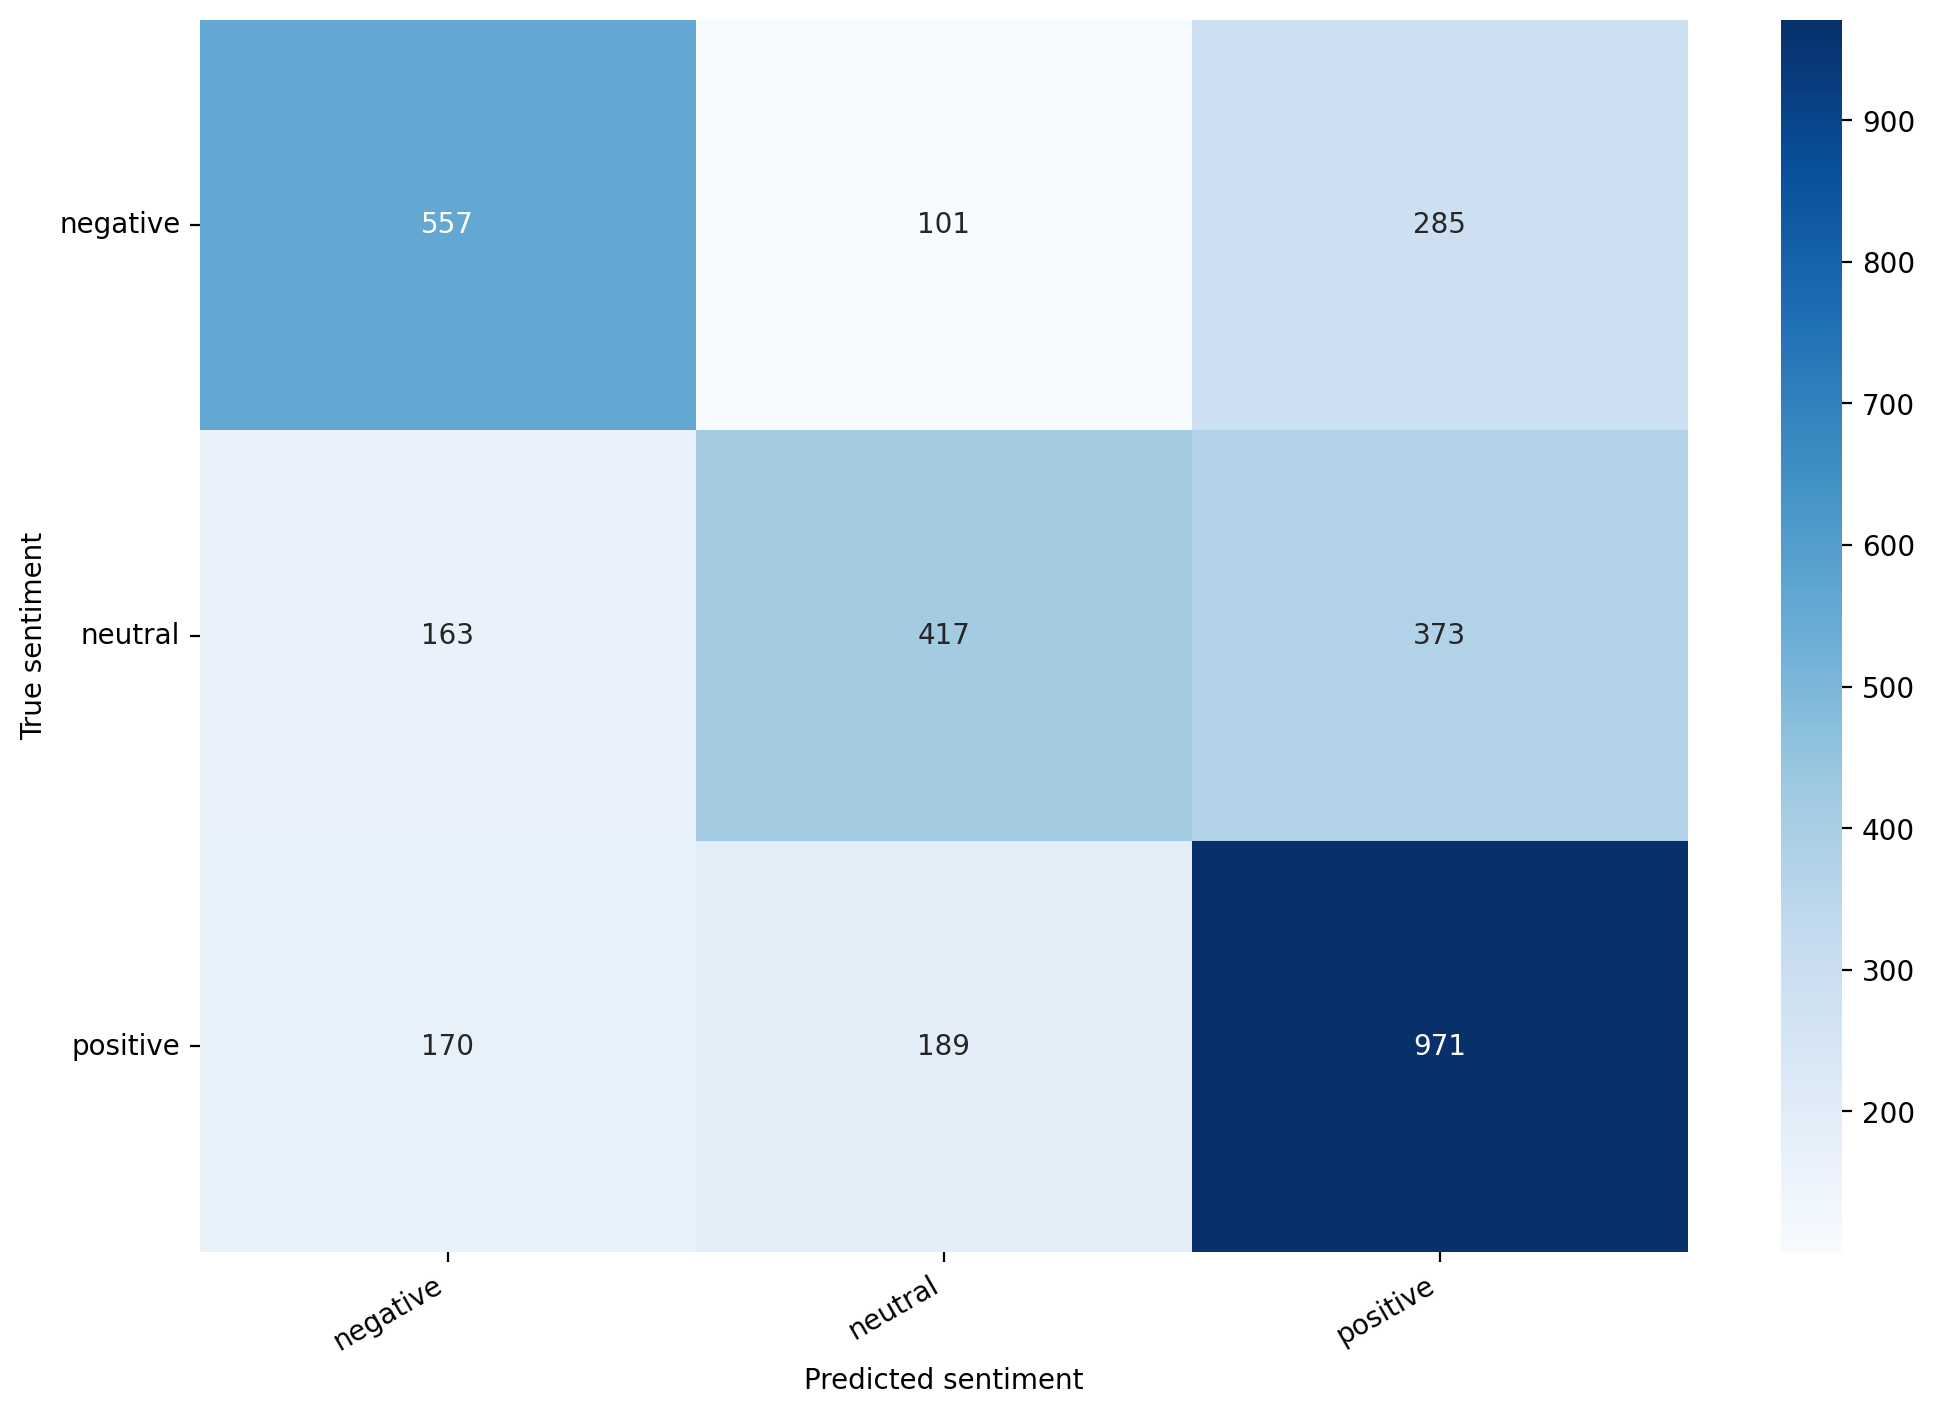

In [ ]:
# ========== 时间段评估：2021年第一季度（Q1） ==========
# 加载并筛选2021年1月-3月的数据
df_ood = pd.read_csv('../data/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-01-01')&(df_ood.DATE<='2021-03-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)

# 数据清洗
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

# 数据预处理
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)

# 生成mask矩阵
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)

# 创建DataLoader
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

# 预测并评估
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

              precision    recall  f1-score   support

    negative     0.6303    0.6677    0.6485       623
     neutral     0.6888    0.4776    0.5641       825
    positive     0.5377    0.6843    0.6022       792

    accuracy                         0.6036      2240
   macro avg     0.6189    0.6099    0.6049      2240
weighted avg     0.6191    0.6036    0.6010      2240



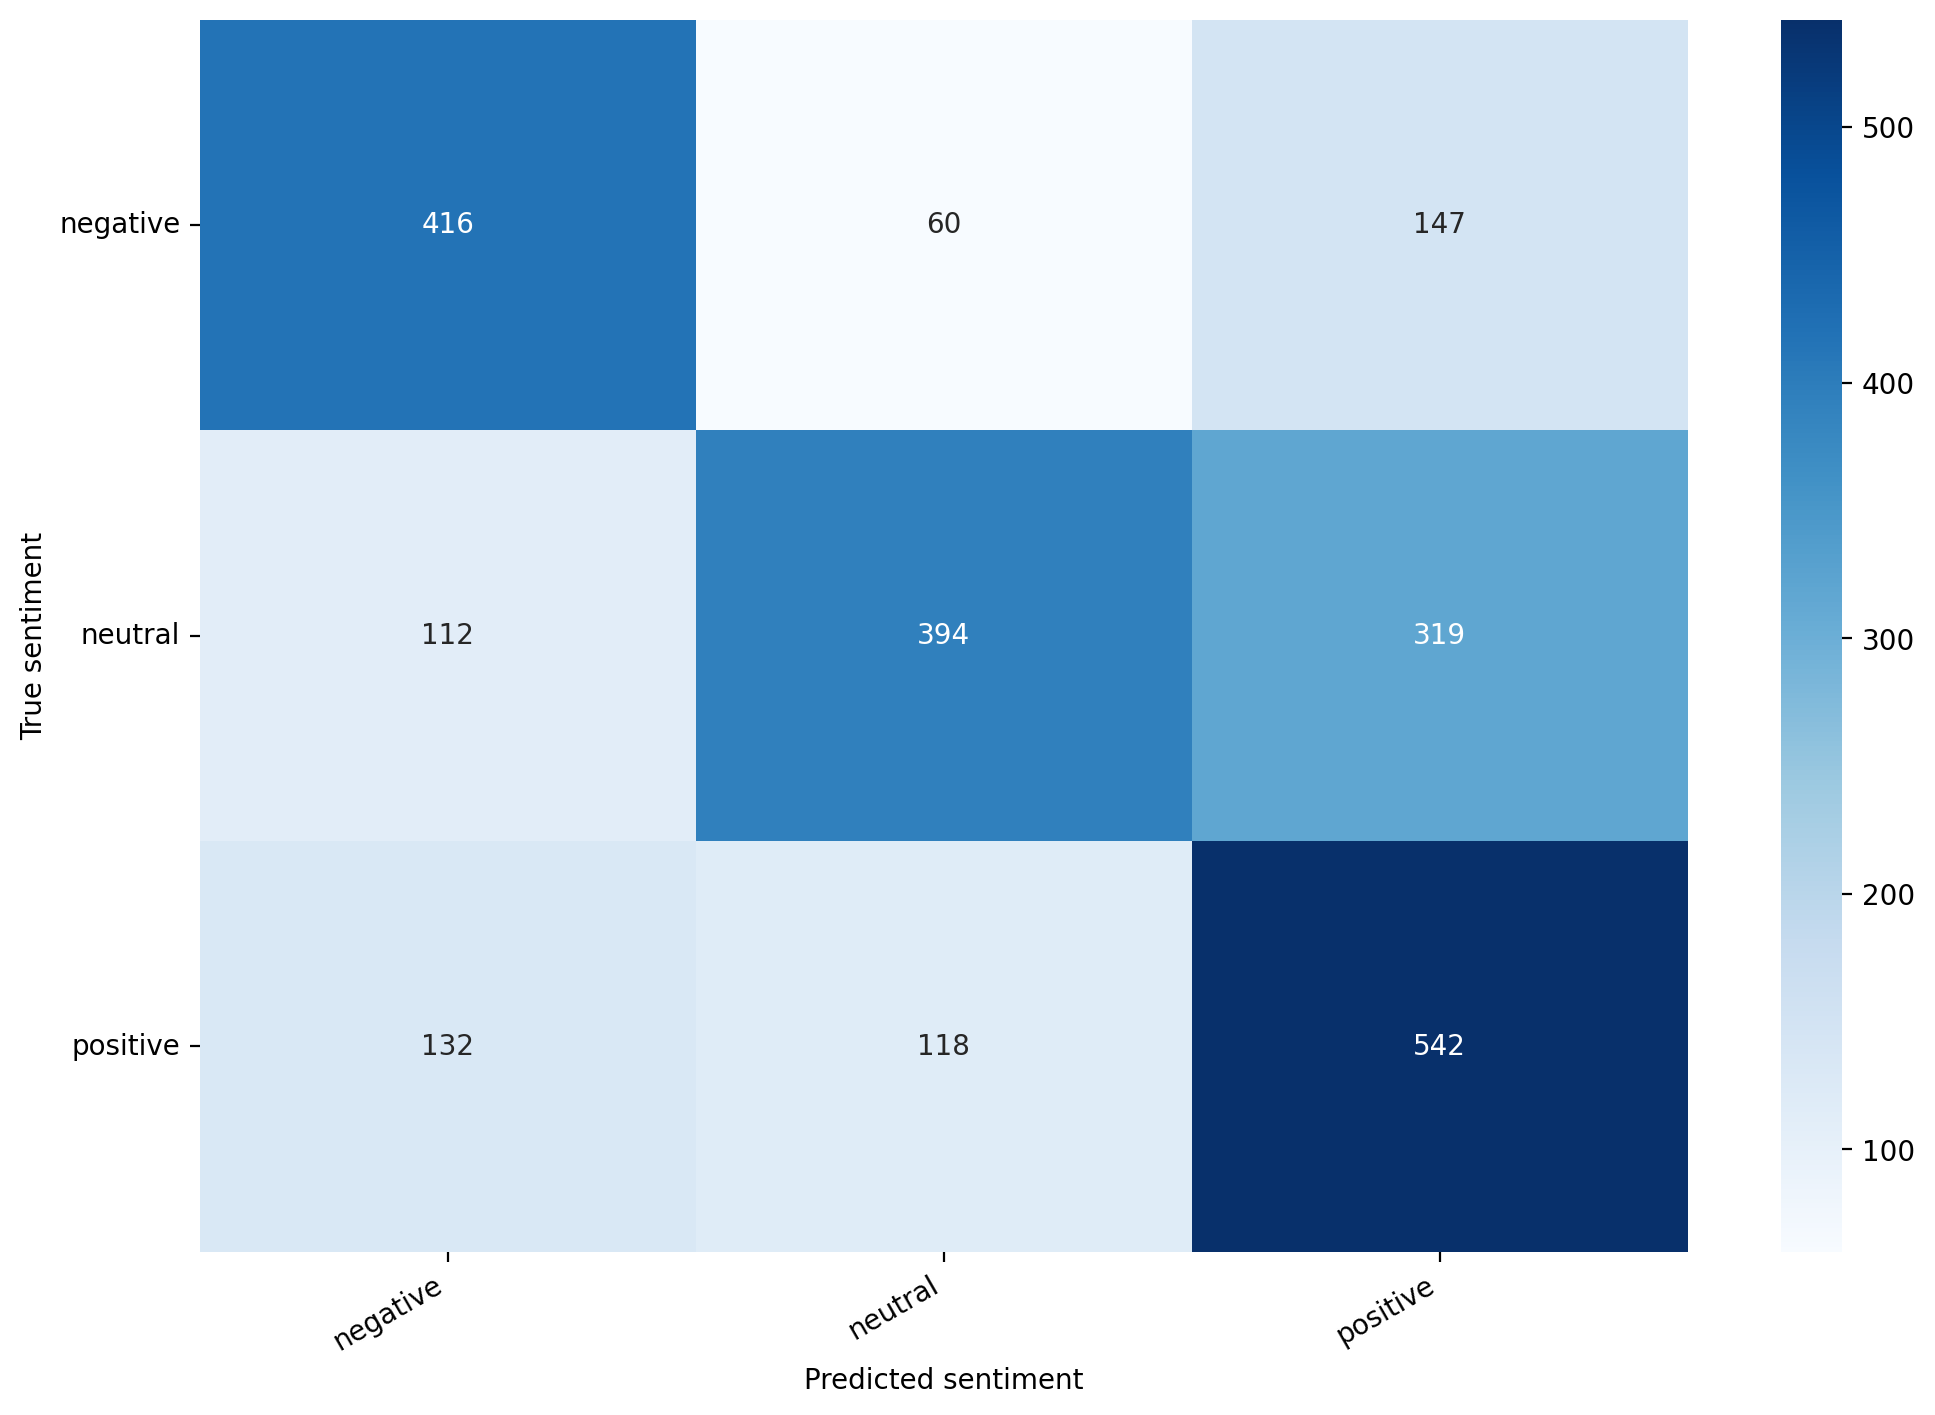

In [ ]:
# ========== 时间段评估：2021年第二季度（Q2） ==========
# 加载并筛选2021年4月-6月的数据
df_ood = pd.read_csv('../data/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-04-01')&(df_ood.DATE<='2021-06-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)

# 数据清洗
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

# 数据预处理
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)

# 生成mask矩阵并创建DataLoader
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

# 预测并评估
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

              precision    recall  f1-score   support

    negative     0.6240    0.6197    0.6219      1157
     neutral     0.5553    0.4679    0.5079      1169
    positive     0.5327    0.6264    0.5758      1092

    accuracy                         0.5699      3418
   macro avg     0.5707    0.5713    0.5685      3418
weighted avg     0.5714    0.5699    0.5682      3418



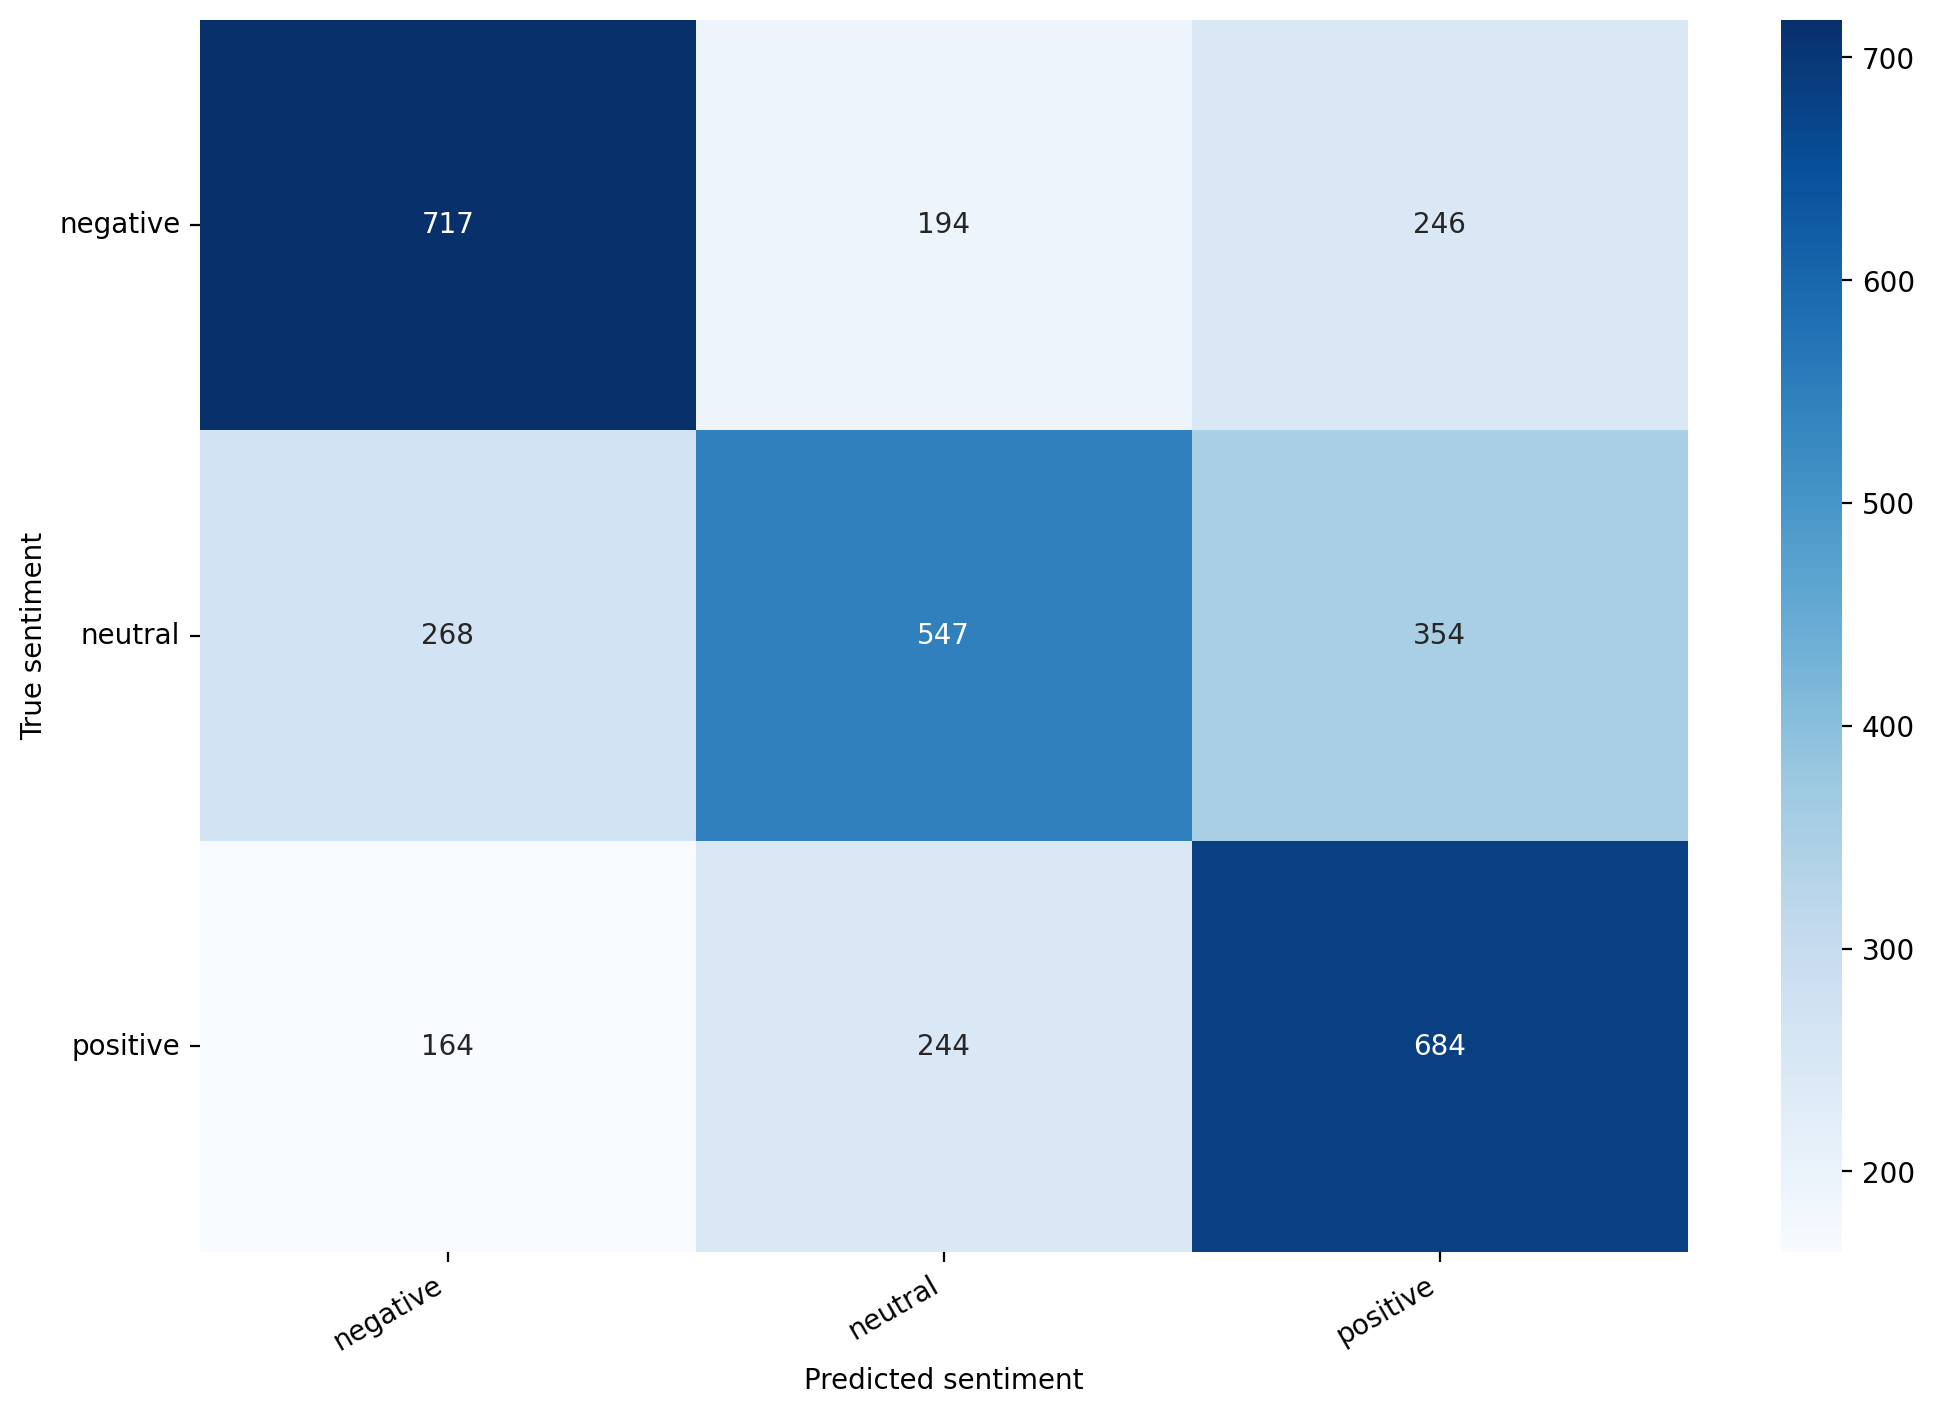

In [ ]:
# ========== 时间段评估：2021年第三季度（Q3） ==========
# 加载并筛选2021年7月-9月的数据
df_ood = pd.read_csv('../data/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-07-01')&(df_ood.DATE<='2021-09-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)

# 数据清洗
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

# 数据预处理
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)

# 生成mask矩阵并创建DataLoader
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

# 预测并评估
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [ ]:
# 安装LIT-NLP可视化工具（已注释）
# !pip install lit-nlp

              precision    recall  f1-score   support

    negative     0.6143    0.6386    0.6262       404
     neutral     0.5325    0.4765    0.5030       447
    positive     0.5121    0.5538    0.5322       381

    accuracy                         0.5536      1232
   macro avg     0.5530    0.5563    0.5538      1232
weighted avg     0.5530    0.5536    0.5524      1232



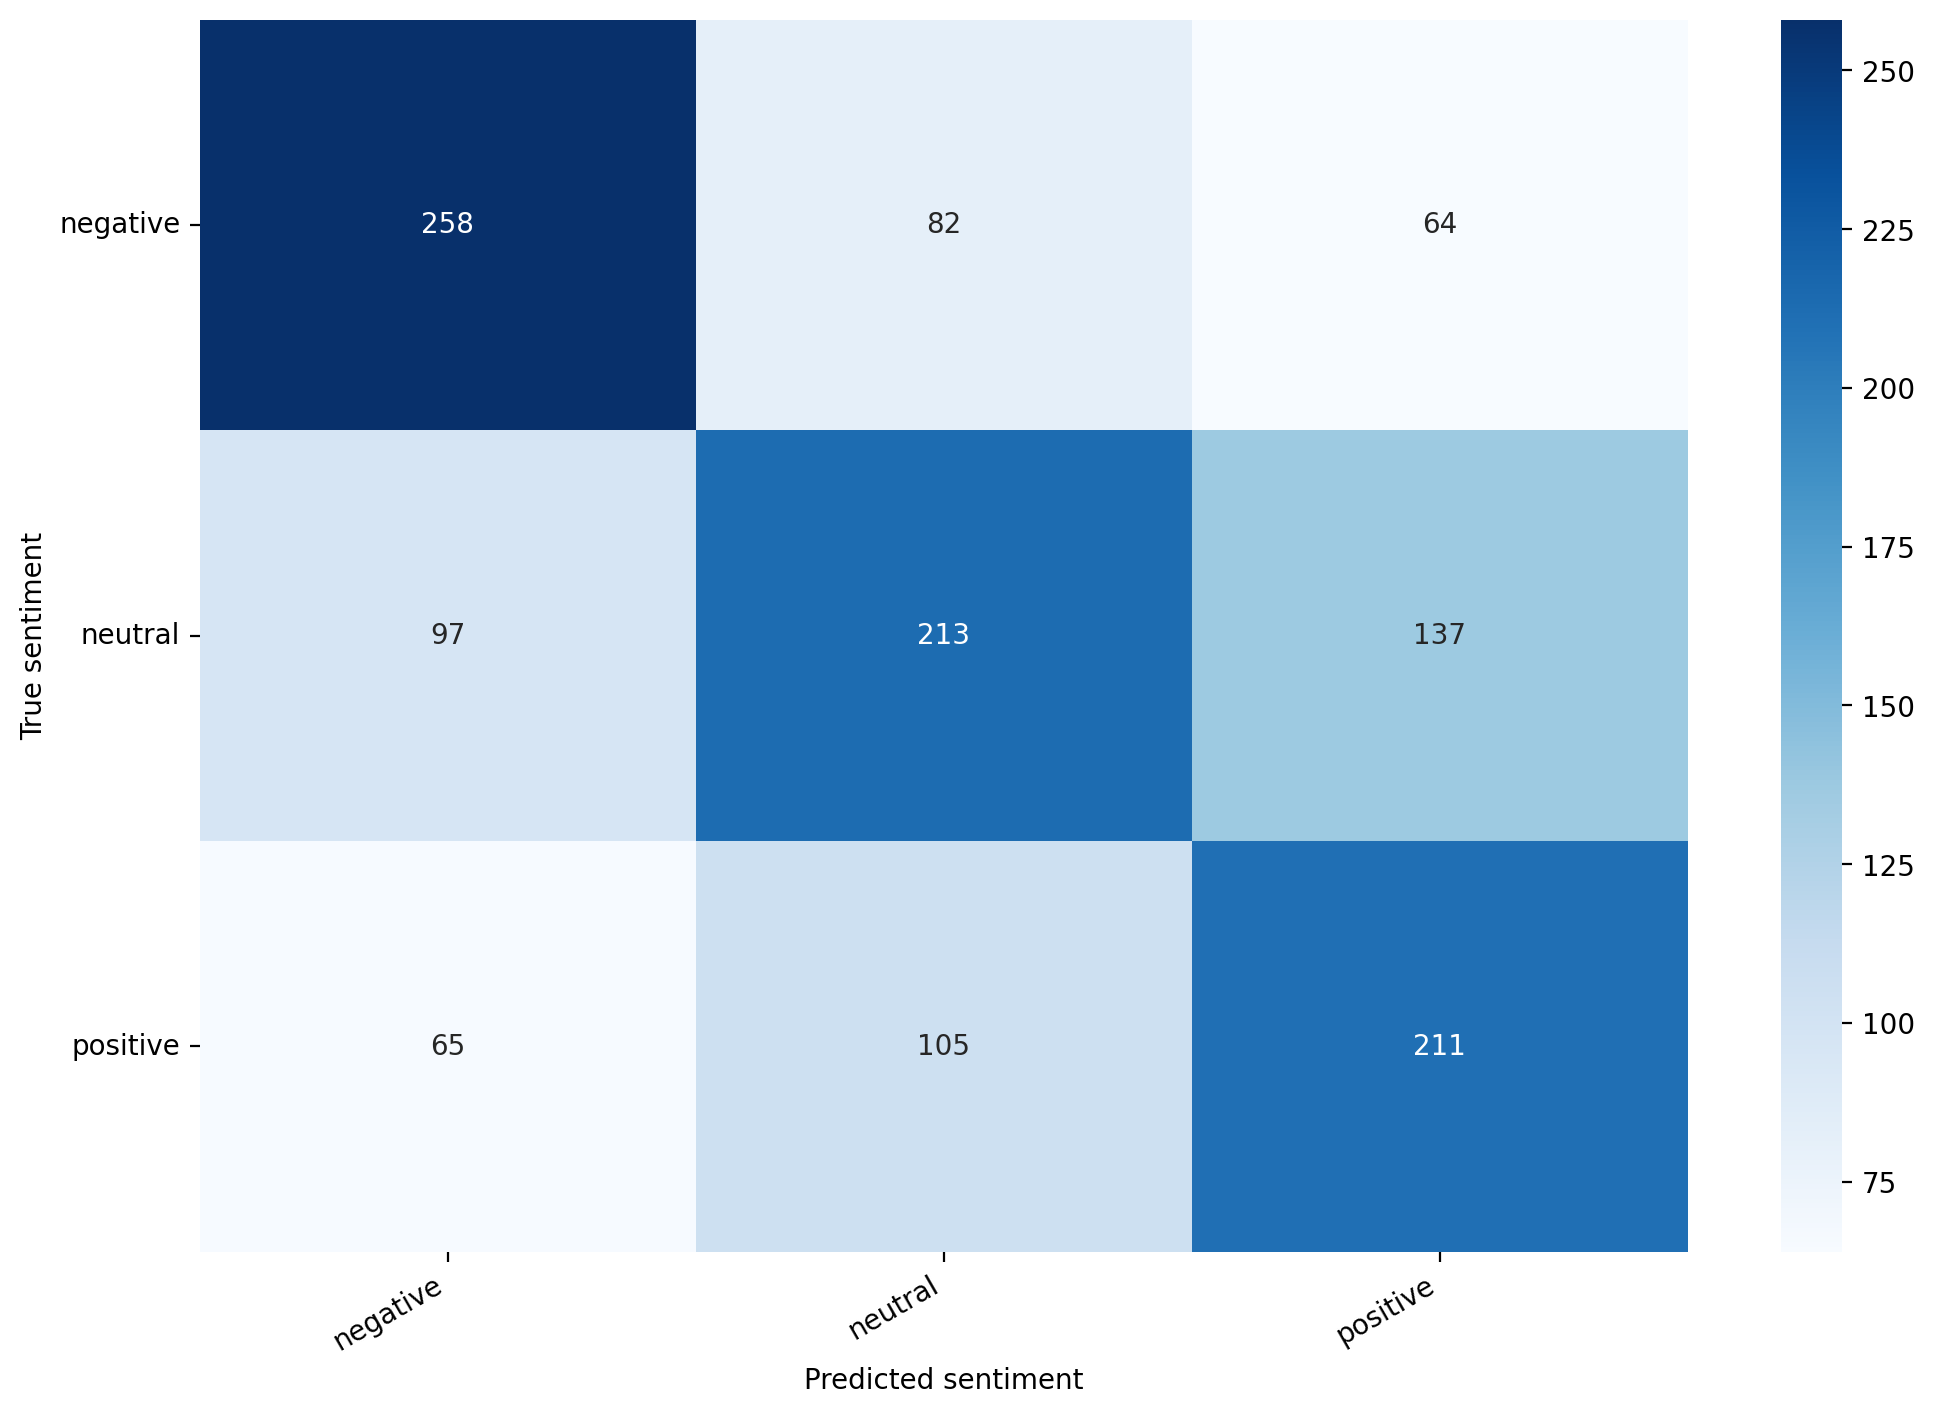

In [ ]:
# ========== 时间段评估：2021年第四季度及之后（Q4+） ==========
# 加载并筛选2021年10月之后的数据
df_ood = pd.read_csv('../data/ood.csv',sep='\t')
df_ood = df_ood.loc[df_ood.DATE>='2021-10-01']
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)

# 数据清洗
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

# 数据预处理
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)

# 生成mask矩阵并创建DataLoader
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

# 预测并评估
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         0
     neutral     1.0000    0.3029    0.4650     16798
    positive     0.0000    0.0000    0.0000         0

    accuracy                         0.3029     16798
   macro avg     0.3333    0.1010    0.1550     16798
weighted avg     1.0000    0.3029    0.4650     16798



/Volumes/移动硬盘/Asotck/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/移动硬盘/Asotck/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Volumes/移动硬盘/Asotck/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


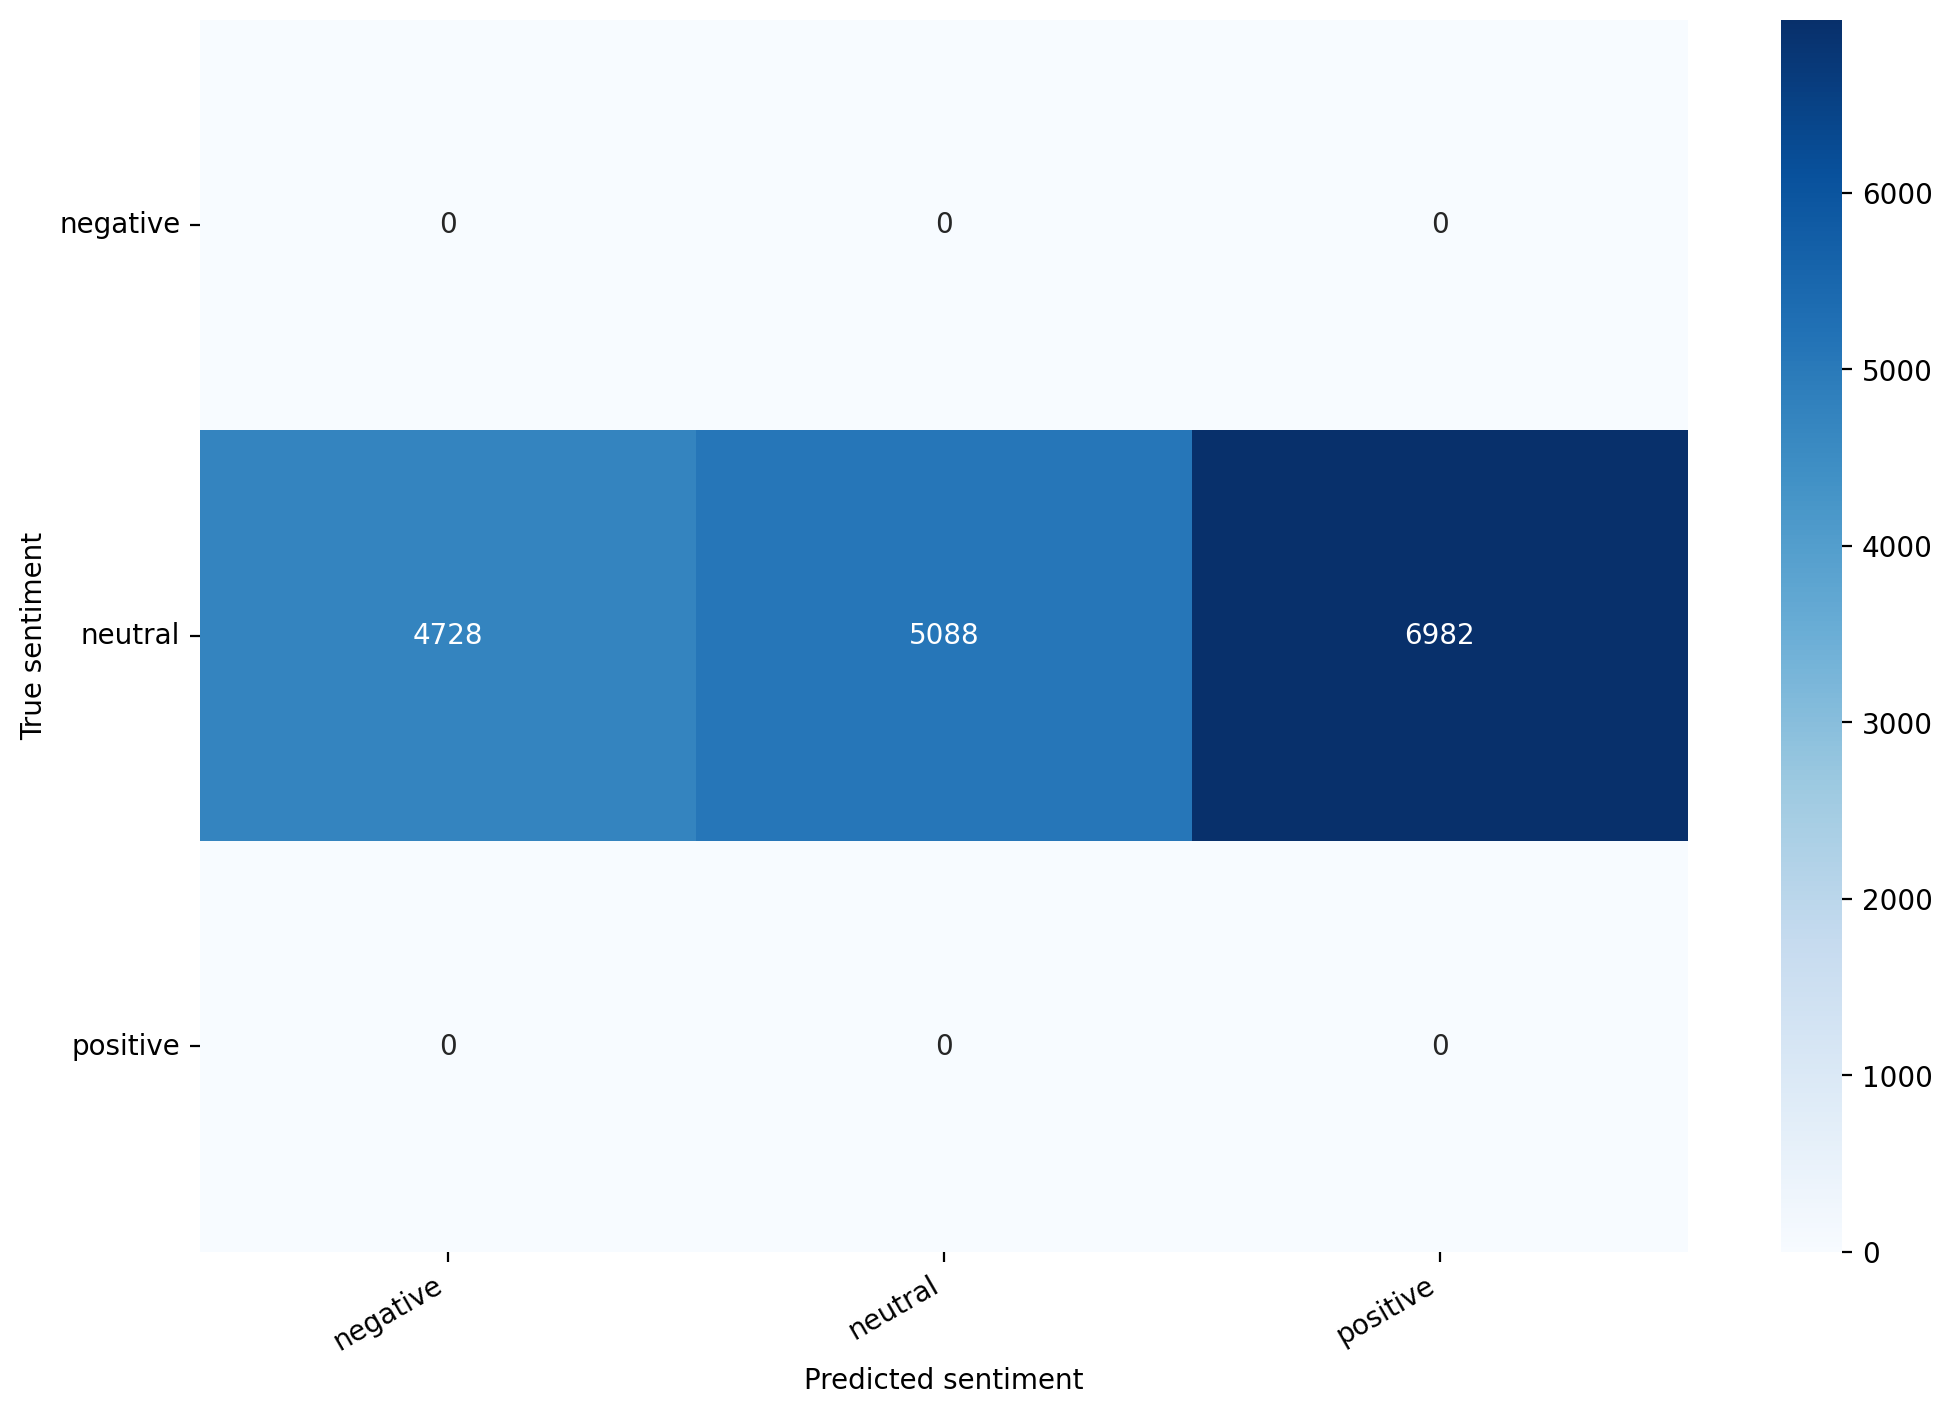

In [ ]:
# ========== 全年数据评估 ==========
# 加载完整的年度数据集进行评估
df_ood = pd.read_csv('../data/df_all_year_srl.csv',sep='\t')
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)

# 数据清洗
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

# 数据预处理
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)

# 生成mask矩阵并创建DataLoader
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

# 预测并评估
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [ ]:
# 保存OOD数据集的预测结果到CSV文件
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Factor24_Pretrained_ROBERT_ood.csv',sep='\t')

In [ ]:
# 保存处理后的数据（此行代码有误，应为 df_ood.to_csv）
# df_ood.to_csv('../data/df_all_year_srl.csv',sep='\t',index=None)

In [ ]:
# ========== LIT-NLP可视化工具 - 数据加载器（已注释） ==========
# 以下代码用于定义LIT-NLP可视化数据集加载器
# from lit_nlp.api.dataset import Dataset
# class MultiNLIData(Dataset):
#   """Loader for MultiNLI development set."""
#   def __init__(self, df):
#     # Read the eval set from a .tsv file as distributed with the GLUE benchmark.
#     # df = pandas.read_csv(path, sep='\t')
#     # Store as a list of dicts, conforming to self.spec()
#     self.LABELS = [0,1]
#     self._examples = [{
#       'sentence': row['DESCRIPTION_EN'],
#       # 'hypothesis': row['sentence2'],
#       'label': row['LABEL']
#       # 'genre': row['genre'],
#     } for _, row in df.iterrows()]
#   def spec(self):
#     return {
#       'sentence': lit_types.TextSegment(),
#       # 'hypothesis': lit_types.TextSegment(),
#       'label': lit_types.CategoryLabel(vocab=self.LABELS),
#       # We can include additional fields, which don't have to be used by the model.
#       # 'genre': lit_types.Label(),
#     }

In [36]:
# from absl import app
# from absl import flags
# from absl import logging

# from lit_nlp import dev_server
# from lit_nlp import server_flags
# from lit_nlp.api import model as lit_model
# from lit_nlp.api import types as lit_types
# # Use the regular GLUE data loaders, because these are very simple already.
# from lit_nlp.examples.datasets import glue
# from lit_nlp.lib import utils

# import torch
# import transformers

# # NOTE: additional flags defined in server_flags.py

# FLAGS = flags.FLAGS

# flags.DEFINE_string(
#     "model_path",
#     "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
#     "Path to trained model, in standard transformers format, e.g. as "
#     "saved by model.save_pretrained() and tokenizer.save_pretrained()")


# def _from_pretrained(cls, *args, **kw):
#   """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
#   try:
#     return cls.from_pretrained(*args, **kw)
#   except OSError as e:
#     logging.warning("Caught OSError loading model: %s", e)
#     logging.warning(
#         "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
#     return cls.from_pretrained(*args, from_tf=True, **kw)


# class SimpleSentimentModel(lit_model.Model):
#   """Simple sentiment analysis model."""

#   LABELS = [0,1]  # negative, positive

#   def __init__(self, model_name_or_path):
#     self.tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path)
#     model_config = transformers.AutoConfig.from_pretrained(
#         model_name_or_path,
#         num_labels=2,
#         output_hidden_states=True,
#         output_attentions=True,
#     )
#     # This is a just a regular PyTorch model.
#     self.model = _from_pretrained(
#         transformers.AutoModelForSequenceClassification,
#         model_name_or_path,
#         config=model_config)
#     self.model.eval()

#   ##
#   # LIT API implementation
#   def max_minibatch_size(self):
#     # This tells lit_model.Model.predict() how to batch inputs to
#     # predict_minibatch().
#     # Alternately, you can just override predict() and handle batching yourself.
#     return 16

#   def predict_minibatch(self, inputs):
#     # Preprocess to ids and masks, and make the input batch.
#     encoded_input = self.tokenizer.batch_encode_plus(
#         [ex["sentence"] for ex in inputs],
#         return_tensors="pt",
#         add_special_tokens=True,
#         max_length=200,
#         padding="longest",
#         truncation="longest_first")

#     # Check and send to cuda (GPU) if available
#     if torch.cuda.is_available():
#       self.model.cuda()
#       for tensor in encoded_input:
#         encoded_input[tensor] = encoded_input[tensor].cuda()
#     # Run a forward pass.
#     with torch.no_grad():  # remove this if you need gradients.
#       out: transformers.modeling_outputs.SequenceClassifierOutput = \
#           self.model(**encoded_input)

#     # Post-process outputs.
#     batched_outputs = {
#         "probas": torch.nn.functional.softmax(out.logits, dim=-1),
#         "input_ids": encoded_input["input_ids"],
#         "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
#         "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
#     }
#     # Return as NumPy for further processing.
#     detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
#     # Unbatch outputs so we get one record per input example.
#     for output in utils.unbatch_preds(detached_outputs):
#       ntok = output.pop("ntok")
#       output["tokens"] = self.tokenizer.convert_ids_to_tokens(
#           output.pop("input_ids")[1:ntok - 1])
#       yield output

#   def input_spec(self) -> lit_types.Spec:
#     return {
#         "sentence": lit_types.TextSegment(),
#         "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
#     }

#   def output_spec(self) -> lit_types.Spec:
#     return {
#         "tokens": lit_types.Tokens(),
#         "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
#         "cls_emb": lit_types.Embeddings()
#     }


In [ ]:
# 创建数据集实例，从训练集中随机抽取1800个样本（已注释）
# dataset = MultiNLIData(df_train.sample(1800))

In [ ]:
# 配置LIT-NLP可视化的数据集和模型（已注释）
# datasets = {"sst_dev": dataset}
# models = {"sst": SimpleSentimentModel("/content/drive/MyDrive/model/best_model/")}
# # models = {"sst": SimpleSentimentModel("bert-base-uncased")}

In [ ]:
# 创建LIT-NLP可视化组件（已注释）
# from lit_nlp import notebook
# widget = notebook.LitWidget(models, datasets, height=800)

In [ ]:
# 获取模型实例（已注释）
# mm = models["sst"]

In [ ]:
# 查看模型配置（已注释）
# mm.model.config

In [ ]:
# 渲染可视化界面（已注释）
# widget.render()

In [ ]:
# 查看数据集标签（已注释）
# dataset.LABELS
